## Pipelines Challenge

In this challenge, we will be working with this [dataset](https://drive.google.com/file/d/1B07fvYosBNdIwlZxSmxDfeAf9KaygX89/view?usp=sharing), where we will be predicting sales. 

**The main goal is to create a `pipeline` that covers all the data preprocessing and modeling steps.**


**TASK 1**: Build a pipeline that ends with a regression model, to predict `Item_Outlet_Sales` from the dataset. 

**The pipeline should have following steps:**

1. Split the features into numerical and categorical (text)
2. Replace null values
    - the mean for numerical variables
    - the most frequent value for categorical variables
3. Create dummy variables from categorical features
4. Use a PCA to reduce number of dummy variables to 3 principal components. PCA will be used directly after the OneHotEncoder that outputs data into a SparseMatrix, so we will need to use the **ToDenseTransformer** from the [article about custom pipelines](https://queirozf.com/entries/scikit-learn-pipelines-custom-pipelines-and-pandas-integration).
5. Select the 3 best candidates from the original numerical features using KBest
6. Fit a Ridge regression (default alpha is fine for now)

**TASK 2**: Tune the parameters of multiple models as well as the preprocessing steps and find the best solution.
- Try these models: 
        - Random Forest Regressor
        - Gradient Boosting Regressor 
        - Ridge Regression. 
- For the task 2, we will need to use the same approach from this [earlier article](https://iaml.it/blog/optimizing-sklearn-pipelines), in the section `PIPELINE TUNING (ADVANCED VERSION)`, where we tried different kinds of scalers. (Use the article as reference.)

_________________________________

In [1]:
import pandas as pd
df = pd.read_csv("regression_exercise.csv")
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [2]:
# creating target variable
y = df["Item_Outlet_Sales"]
df = df.drop(["Item_Outlet_Sales","Item_Identifier"],axis = 1)

Split the dataset into a train and test set.

**Note:** We should always do this at the beginning before the pipeline.

In [3]:
df_train = df.sample(frac=0.8).sort_index()
y_train = y[y.index.isin(df_train.index.tolist())]

In [4]:
df_test = df[~df.index.isin(df_train.index.tolist())].sort_index()
y_test = y[y.index.isin(df_test.index.tolist())]

In [5]:
print(df_train.shape)
print(y_train.shape)
print(df_test.shape)
print(y_test.shape)

(6818, 10)
(6818,)
(1705, 10)
(1705,)


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6818 entries, 0 to 8521
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                5642 non-null   float64
 1   Item_Fat_Content           6818 non-null   object 
 2   Item_Visibility            6818 non-null   float64
 3   Item_Type                  6818 non-null   object 
 4   Item_MRP                   6818 non-null   float64
 5   Outlet_Identifier          6818 non-null   object 
 6   Outlet_Establishment_Year  6818 non-null   int64  
 7   Outlet_Size                4889 non-null   object 
 8   Outlet_Location_Type       6818 non-null   object 
 9   Outlet_Type                6818 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 585.9+ KB


---------------------
## Task I

### Split Features into numerical and categorical

In [7]:
cat_feats = df.dtypes[df.dtypes == 'object'].index.tolist()
num_feats = df.dtypes[~df.dtypes.index.isin(cat_feats)].index.tolist()

In [8]:
from sklearn.preprocessing import FunctionTransformer

# Using own function in Pipeline
def numFeat(data):
    return data[num_feats]

def catFeat(data):
    return data[cat_feats]

In [9]:
# we will start two separate pipelines for each type of features
keep_num = FunctionTransformer(numFeat)
keep_cat = FunctionTransformer(catFeat)

In [18]:
type(keep_num)

sklearn.preprocessing._function_transformer.FunctionTransformer

### replacing null values

In [10]:
# Use SimpleImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# define individual transformers in a pipeline
numerical_preprocessing = Pipeline([('imputation', SimpleImputer(strategy='mean'))])
categorical_preprocessing = Pipeline([('imputation', SimpleImputer(strategy='most_frequent'))])

### Creating dummy variables

In [11]:
# use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

categorical_preprocessing = Pipeline([('imputation', SimpleImputer(strategy='most_frequent')),
                                    ('ohe',OneHotEncoder(sparse=False))])

### Use PCA to reduce the number of dummy variables to 3 principal components.

In [12]:
from sklearn.decomposition import PCA

categorical_preprocessing = Pipeline([('imputation', SimpleImputer(strategy='most_frequent')),
                                    ('ohe',OneHotEncoder(sparse=False)),
                                    ('pca', PCA(n_components=3))])

### Select the 3 best numeric features

In [13]:
# use SelectKBest
from sklearn.feature_selection import SelectKBest

numerical_preprocessing = Pipeline([('imputation', SimpleImputer(strategy='mean')),
                                    ('select', SelectKBest(k=3))])

### Fitting models

In [14]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Use base_model in Task I
base_model = Ridge()

### Building a Pipeline

In [15]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


In [59]:
categorical_preprocessing = Pipeline([('keep_cat', FunctionTransformer(catFeat)),
                                    ('imputation', SimpleImputer(strategy='most_frequent')),
                                    ('ohe',OneHotEncoder(sparse=False))])

numerical_preprocessing = Pipeline([('keep_num', FunctionTransformer(numFeat)),
                                    ('imputation', SimpleImputer(strategy='mean')),
                                    ('scaling', StandardScaler())])

preprocessing = ColumnTransformer([('numeric', numerical_preprocessing, num_feats),
                                    ('categorical', categorical_preprocessing, cat_feats)])

feature_union = FeatureUnion([('pca', PCA(n_components=3)), 
                              ('select_best', SelectKBest(k=3))])

pipeline = Pipeline([('preprocessing', preprocessing),
                    ('selection', feature_union),
                    ('model',Ridge())])

pipeline.fit(df_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('keep_num',
                                                                   FunctionTransformer(func=<function numFeat at 0x0000018E1357DE50>)),
                                                                  ('imputation',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['Item_Weight',
                                                   'Item_Visibility',
                                                   'Item_MRP',
                                                   'Outlet_Establishment_Year']),
                                                 ('categorical',
                                                  Pipeline(steps=[('keep_cat',
                                                                   Fu...0x0000018E54378550>)),
                                                                  ('imputation',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Item_Fat_Content',
                                                   'Item_Type',
                                                   'Outlet_Identifier',
                                                   'Outlet_Size',
                                                   'Outlet_Location_Type',
                                                   'Outlet_Type'])])),
                ('selection',
                 FeatureUnion(transformer_list=[('pca', PCA(n_components=3)),
                                                ('select_best',
                                                 SelectKBest(k=3))])),
                ('model', Ridge())])

In [64]:
print(f'Training score: {pipeline.score(df_train, y_train)}')
print(f'Test score: {pipeline.score(df_test, y_test)}')

Training score: 0.5210637998797679
Test score: 0.514504949151328


In [54]:
y_pred = pipeline.predict(df_test)

y_compare = pd.DataFrame([y_test.to_numpy(), y_pred], index=['y_test', 'y_pred'])
y_compare.T

,y_test,y_pred
0,732.3800,1014.477683
1,994.7052,1608.289642
2,343.5528,1649.347339
3,4064.0432,3051.645685
4,2741.7644,1467.264989
...,...,...
1700,2479.4392,3489.360271
1701,595.2252,1600.767838
1702,1571.2880,2435.404210
1703,549.2850,1741.992183


<AxesSubplot: xlabel='Item_Outlet_Sales'>

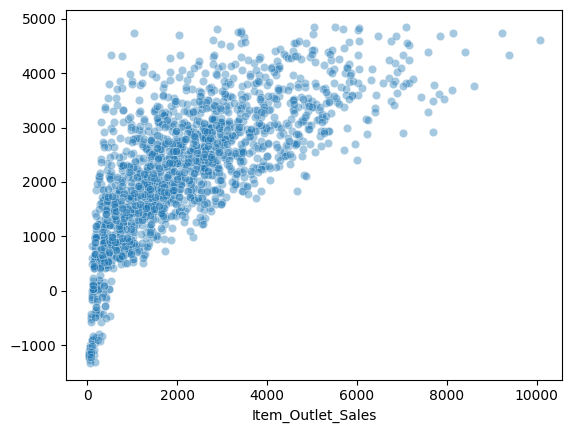

In [63]:
import seaborn as sns

sns.scatterplot(y_compare.T, x=y_test, y=y_pred, alpha=0.4)

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = pipeline.predict(df_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

MSE: 1386989.7900694967
MAE: 876.1841865457927


In [65]:
# from sklearn.model_selection import cross_val_score

# cross_val_score(pipeline, df_train, y_train, cv=3, scoring='neg_root_mean_squared_error')

In [ ]:
# model.score(df_test,y_test)

----------------------------
## Task II

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, Normalizer, MaxAbsScaler
import matplotlib.pyplot as plt
import pickle

In [ ]:
categorical_preprocessing = Pipeline([('keep_cat', FunctionTransformer(catFeat)),
                                    ('imputation', SimpleImputer(strategy='most_frequent')),
                                    ('ohe',OneHotEncoder(sparse=False))])

numerical_preprocessing = Pipeline([('keep_num', FunctionTransformer(numFeat)),
                                    ('imputation', SimpleImputer(strategy='mean')),
                                    ('scaling', StandardScaler())])

preprocessing = ColumnTransformer([('numeric', numerical_preprocessing, num_feats),
                                    ('categorical', categorical_preprocessing, cat_feats)])

feature_union = FeatureUnion([('pca', PCA()), 
                              ('select_best', SelectKBest())])

In [85]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([('preprocessing', preprocessing),
                    ('selection', feature_union),
                    ('model',RandomForestRegressor())])

# Find the best hyperparameters using GridSearchCV on the train set
param_grid = {'preprocessing__numeric__scaling': [StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()],
              'model__n_estimators': [80, 100, 120],
              'model__max_depth': [5, 6, 7], 
              'selection__pca__n_components': [4, 5, 6],
              'selection__select_best__k': [2, 3, 4]}
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid.fit(df_train, y_train)

best_model = grid.best_estimator_
best_hyperparams = grid.best_params_
training_acc = grid.score(df_train, y_train)
best_acc = grid.score(df_test, y_test)
print(f'Training set accuracy: {training_acc}\nBest test set accuracy: {best_acc}\nAchieved with hyperparameters: {best_hyperparams}')

Training set accuracy: 0.6164367436014475
Best test set accuracy: 0.5830117975297406
Achieved with hyperparameters: {'model__max_depth': 5, 'model__n_estimators': 80, 'preprocessing__numeric__scaling': MinMaxScaler(), 'selection__pca__n_components': 4, 'selection__select_best__k': 2}


In [86]:
filename = 'tuned_rf_model.pickle'
pickle.dump(grid, open(filename, 'wb'))

In [78]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline([('preprocessing', preprocessing),
                    ('selection', feature_union),
                    ('model',GradientBoostingRegressor())])

# Find the best hyperparameters using GridSearchCV on the train set
param_grid = {'preprocessing__numeric__scaling': [StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()],
              'selection__pca__n_components': [3, 5],
              'selection__select_best__k': [1, 3, 6],
              'model__learning_rate': [0.1, 0.3, 0.5],
              'model__n_estimators': [100, 150, 200],
              'model__max_depth': [2, 4, 6],}
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid.fit(df_train, y_train)

best_model = grid.best_estimator_
best_hyperparams = grid.best_params_
training_acc = grid.score(df_train, y_train)
best_acc = grid.score(df_test, y_test)
print(f'Training set accuracy: {training_acc}\nBest test set accuracy: {best_acc}\nAchieved with hyperparameters: {best_hyperparams}')

Training set accuracy: 0.6246848099635827
Best test set accuracy: 0.582422435648689
Achieved with hyperparameters: {'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__n_estimators': 100, 'preprocessing__numeric__scaling': MaxAbsScaler(), 'selection__pca__n_components': 3, 'selection__select_best__k': 6}


In [80]:
import pickle

filename = 'tuned_gb_model.pickle'
pickle.dump(grid, open(filename, 'wb'))

In [81]:
# Ridge Regressor
from sklearn.preprocessing import MinMaxScaler, Normalizer, MaxAbsScaler

pipeline = Pipeline([('preprocessing', preprocessing),
                    ('selection', feature_union),
                    ('model',Ridge())])

# Find the best hyperparameters using GridSearchCV on the train set
param_grid = {'preprocessing__numeric__scaling': [StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()],
              'model__alpha': [0.1, 0.3, 0.5],
              'selection__pca__n_components': [3, 5],
              'selection__select_best__k': [1, 3, 6]}
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid.fit(df_train, y_train)

best_model = grid.best_estimator_
best_hyperparams = grid.best_params_
training_acc = grid.score(df_train, y_train)
best_acc = grid.score(df_test, y_test)
print(f'Training set accuracy: {training_acc}\nBest test set accuracy: {best_acc}\nAchieved with hyperparameters: {best_hyperparams}')

Training set accuracy: 0.5638368928137905
Best test set accuracy: 0.5550925964696196
Achieved with hyperparameters: {'model__alpha': 0.1, 'preprocessing__numeric__scaling': Normalizer(), 'selection__pca__n_components': 5, 'selection__select_best__k': 6}


In [82]:
filename = 'tuned_rr_model.pickle'
pickle.dump(grid, open(filename, 'wb'))

In [87]:
filename = 'tuned_rf_model.pickle'
tuned_rf_model = pickle.load(open(filename, 'rb'))

In [88]:
print('Final score is: ', tuned_rf_model.score(df_test, y_test))

Final score is:  0.5830117975297406
